In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing and file IO
import matplotlib.pyplot as plt # visualize images
from scipy.stats import mode
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D
from keras import optimizers

# evaluate label propagation on the semi-supervised learning dataset from numpy import concatenate

import seaborn as sns
from tensorflow.python.client import device_lib 
import tensorflow as tf
from tensorflow.keras import layers,models

from sklearn.model_selection import train_test_split
from keras.layers import concatenate

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix

### Train Data 함수

In [2]:
# Not included in the problem slides.
def Data_visualization(Y):
    ratios = np.sum(Y, axis=0) / Y.shape[0]
    labels = ['Barren Land', 'Trees', 'Grassland', 'Other']
    
    for l, v in zip(labels, ratios * 100):
        print('{}: {:.1f}%'.format(l, v))
        
    cmap = plt.get_cmap('Pastel1')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]
    
    plt.pie(ratios, labels = labels, autopct='%.1f%%', shadow=True, colors=colors)
    plt.show()
    return ratios

### 평가 histogram 함수

In [3]:
def visulization_by_epochs(y_vaccuracy, y_accuracy):
    print(y_vaccuracy.index(max(y_vaccuracy)) + 1, ' ',max(y_vaccuracy)) 

    x_len = np.arange(len(y_accuracy))

    plt.plot(x_len, y_vaccuracy, marker='.', c='red', label="Validation-set Los")
    plt.plot(x_len, y_accuracy, marker='.', c='blue', label="Train-set Loss")

    plt.legend(loc='upper right') 
    plt.grid() 
    plt.xlabel('epoch') 
    plt.ylabel('accuracy') 
    plt.show()

### Confusion Matirx 그리는 함수

In [4]:
#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
def draw_confusionmatrix(y_predict, y_test):
    new_y_predict = []

    for y in y_predict:
        best_y = np.where(y == max(y))
        new_array = np.array([0, 0, 0, 0])
        new_array[best_y] = 1
        new_y_predict.append(new_array)

    new_y_predict = np.array(new_y_predict)


    cf = confusion_matrix(new_y_predict.argmax(axis = 1), y_test.argmax(axis = 1))
    f = sns.heatmap(cf, annot=True, fmt='d')

### 기초통계값 출력 함수

In [5]:
def print_stat(y_res_add):
    res_y_max = []

    for y in y_res_add:
        res_y_max.append(float(max(y)))

    print('최빈값: ', mode(res_y_max))
    print('평균: ', np.median(res_y_max))
    print('분산: ', np.var(res_y_max))
    print('표준편차: ', np.std(res_y_max))
    print('사분위1: ', np.quantile(res_y_max, 0.25))
    print('사분위2(중앙값): ', np.quantile(res_y_max, 0.5))
    print('사분위3: ', np.quantile(res_y_max, 0.75))

    hist, edges = np.histogram(res_y_max, 100)
    sns.distplot(res_y_max, bins = 10, kde = False)

    count_under = 0
    count_upper = 0
    for y in res_y_max:
        if y < 0.9:
            count_under += 1
        else:
            count_upper += 1

    print('0.9 이하 개수: ', count_under)
    print('0.9 이상 개수: ', count_upper)


In [6]:
class MyCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.95):
            print("\n====Reached 95% accuracy, stop training====")
            self.stop_training = True
            
callbacks = MyCallBack()

### Data 불러오기

In [7]:
#Train Data 불러오기
X_train_path = 'data/X_train.csv' 
Y_train_path = 'data/y_train.csv'

X_train_df = pd.read_csv(X_train_path, header=None)
Y_train_df = pd.read_csv(Y_train_path, header=None)

X_train = X_train_df.values / 255
Y_train = Y_train_df.values

n_images = X_train.shape[0]
shape = [n_images, 28, 28, 4]
X_train_img = X_train.reshape(shape) 
print(X_train_img.shape) 
print('Train_img') 
print(Y_train.shape)


#ADD Data 불러오기
X_add_path = 'data/X_add.csv' 
X_add_df = pd.read_csv(X_add_path, header=None) 

X_add = X_add_df.values / 255
n_add_images = X_add.shape[0]
add_shape = [n_add_images, 28, 28, 4]
X_add_img = X_add.reshape(add_shape)
print('ADD_img')
print(X_add_img.shape)

#Test Data 불러오기
X_test_path = 'data/X_test.csv' 
Y_test_path = 'data/y_test.csv'

X_test_df = pd.read_csv(X_test_path, header=None)
Y_test_df = pd.read_csv(Y_test_path, header=None)

X_test = X_test_df.values / 255 
Y_test = Y_test_df.values 

n_test_images = X_test.shape[0]
test_shape = [n_test_images, 28, 28, 4] 
print('Test_img')
X_test_img = X_test.reshape(test_shape)
print(X_test_img.shape)
print(Y_test.shape)

(2000, 28, 28, 4)
Train_img
(2000, 4)
ADD_img
(10000, 28, 28, 4)
Test_img
(10000, 28, 28, 4)
(10000, 4)


### Train Data 시각화

X_train_img:  2000
Y_train:  2000
Barren Land: 12.5%
Trees: 12.5%
Grassland: 25.0%
Other: 50.0%


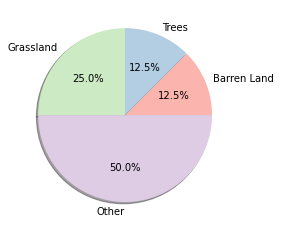

array([0.125, 0.125, 0.25 , 0.5  ])

In [8]:
print('X_train_img: ', len(X_train_img))
print('Y_train: ', len(Y_train))
Data_visualization(Y_train)

### Train Data의 양이 너무 부족, Augmentation이 요구됨

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen2 = ImageDataGenerator(
    rotation_range=15, #15도 회전
    horizontal_flip = True, #상하반전
    vertical_flip = True) # 좌우반전

datagen3 = ImageDataGenerator(
    #rotation_range=15, #15도 회전
    horizontal_flip = True, #상하반전
    vertical_flip = False) # 좌우반전

datagen4 = ImageDataGenerator(
    #rotation_range=15, #15도 회전
    horizontal_flip = False, #상하반전
    vertical_flip = True) # 좌우반전


In [10]:
data_2 = datagen2.flow(x=X_train_img, y=Y_train, batch_size = 2000)
X_2, y_2 = data_2.next()

data_3 = datagen3.flow(x=X_train_img, y=Y_train, batch_size = 2000)
X_3, y_3 = data_2.next()

data_4 = datagen4.flow(x=X_train_img, y=Y_train, batch_size = 2000)
X_4, y_4 = data_4.next()

In [11]:
aug_X = np.concatenate((X_train_img, X_2, X_3, X_4), axis=0)
aug_Y = np.concatenate((Y_train, y_2, y_3, y_4), axis=0)

aug_X:  8000
aug_Y:  8000
Barren Land: 12.5%
Trees: 12.5%
Grassland: 25.0%
Other: 50.0%


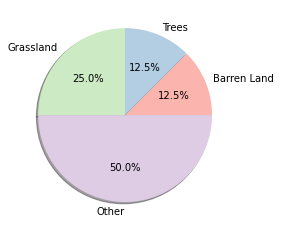

array([0.125, 0.125, 0.25 , 0.5  ])

In [12]:
print('aug_X: ',len(aug_X))
print('aug_Y: ',len(aug_Y))
Data_visualization(aug_Y)

In [38]:
#x_train, x_val, y_train, y_val = train_test_split(X_train_img, Y_train, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(aug_X, aug_Y, test_size = 0.2)

### Train Data 시각화

### 이슈
### 1. Tensorflow에서 제공하는 Transfer model은 3차원 Input을 요구
### 하지만 보유한 Data는 4차원-->받은 PreTrained Model의 구조를 일부변경

### VGG16 Base Model

In [39]:
inputs = Input(shape = (32, 32, 4))

# block 1
x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block1_conv1')(inputs)
x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block1_conv2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='block1_pool')(x)

# block 2
x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block2_conv1')(x)
x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block2_conv2')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='block2_pool')(x)

# block 3
x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block3_conv1')(x)
x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block3_conv2')(x)
x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block3_conv3')(x)
x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block3_conv4')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='block3_pool')(x)

# block 4
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block4_conv1')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block4_conv2')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block4_conv3')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block4_conv4')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='block4_pool')(x)

# block 5
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block5_conv1')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block5_conv2')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block5_conv3')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block5_conv4')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='block5_pool', padding='same')(x)


Feature_vgg = Model(inputs=inputs, outputs=x)

### VGG 16

In [23]:
VGG16_model = tf.keras.applications.vgg16.VGG16(input_shape = (32,32,3), 
                                                include_top = False,
                                                weights = 'imagenet')

In [24]:
model = Feature_vgg  # your RGBY model is here
pretrained_model = VGG16_model  # pretrained RGB model

# the following assumes that the layers match with the two models and
# only the shapes of weights and/or biases are different
for pretrained_layer, layer in zip(pretrained_model.layers, model.layers):
    pretrained = pretrained_layer.get_weights()
    target = layer.get_weights()
    if len(pretrained) == 0:  # skip input, pooling and other no weights layers
        continue
    try:  
        # set the pretrained weights as is whenever possible
        layer.set_weights(pretrained)
    except:
        # numpy.resize to the rescue whenever there is a shape mismatch
        for idx, (l1, l2) in enumerate(zip(pretrained, target)):
            target[idx] = np.resize(l1, l2.shape)

        layer.set_weights(target)

In [25]:
print('Feature 동결한 후 훈련되는 가중치의 수:', len(Feature_vgg.trainable_weights))
#Feature.trainable = False
#print('Feature 동결한 후 훈련되는 가중치의 수:', len(Feature.trainable_weights))

Feature 동결한 후 훈련되는 가중치의 수: 32


In [40]:
img_shape = (X_train_img[1], X_train_img[2], X_train_img[3])
model_vgg = models.Sequential()
# For training from scratch change kernel_initializer to e.g.'VarianceScaling'
model_vgg.add(layers.ZeroPadding2D(padding = (2,2), input_shape = (28, 28 ,4)))
model_vgg.add(Feature_vgg)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(256, activation='relu'))
model_vgg.add(layers.Dense(128, activation='relu'))
model_vgg.add(layers.Dense(4, activation='sigmoid'))

model_vgg.compile(optimizer=optimizers.RMSprop(),
                     loss='categorical_crossentropy',
                     metrics=['acc'])

In [41]:
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_3 (ZeroPaddin (None, 32, 32, 4)         0         
_________________________________________________________________
model_3 (Functional)         (None, 1, 1, 512)         20024960  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 516       
Total params: 20,189,700
Trainable params: 20,189,700
Non-trainable params: 0
__________________________________________

In [42]:
history_vgg = model_vgg.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
200/200 [==============================] - 10s 42ms/step - loss: 1.3612 - acc: 0.4922 - val_loss: 1.3097 - val_acc: 0.4894
Epoch 2/30
200/200 [==============================] - 8s 41ms/step - loss: 1.2901 - acc: 0.5015 - val_loss: 1.2631 - val_acc: 0.4894
Epoch 3/30
200/200 [==============================] - 8s 41ms/step - loss: 1.2404 - acc: 0.5089 - val_loss: 1.2398 - val_acc: 0.4894
Epoch 4/30
200/200 [==============================] - 8s 41ms/step - loss: 1.2289 - acc: 0.4940 - val_loss: 1.2316 - val_acc: 0.4894
Epoch 5/30
200/200 [==============================] - 8s 41ms/step - loss: 1.2085 - acc: 0.5063 - val_loss: 1.2299 - val_acc: 0.4894
Epoch 6/30
200/200 [==============================] - 8s 41ms/step - loss: 1.2037 - acc: 0.5059 - val_loss: 1.2299 - val_acc: 0.4894
Epoch 7/30
200/200 [==============================] - 8s 41ms/step - loss: 1.2055 - acc: 0.5057 - val_loss: 1.2302 - val_acc: 0.4894
Epoch 8/30
200/200 [==============================] - 8s 41ms/step -

1   0.4893749952316284


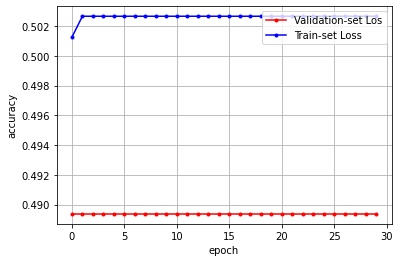

63/63 [==============================] - 1s 9ms/step - loss: 1.2131 - acc: 0.5000
[1.2130876779556274, 0.5]


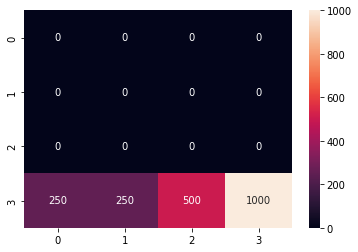

In [43]:
vgg_y_vaccuracy = history_vgg.history['val_acc'] 
vgg_y_accuracy = history_vgg.history['acc']

visulization_by_epochs(vgg_y_vaccuracy, vgg_y_accuracy)

result = model_vgg.evaluate(X_train_img, Y_train)
print(result)
#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_vgg.predict(X_train_img)

draw_confusionmatrix(y_predict, Y_train)

### ResNet

In [44]:
inputs = Input(shape=(32, 32, 4))

# block 1
x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block1_conv1')(inputs)
x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block1_conv2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='block1_pool')(x)

# block 2
x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block2_conv1')(x)
x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block2_conv2')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='block2_pool')(x)

# block 3
x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block3_conv1')(x)
x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block3_conv2')(x)
x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block3_conv3')(x)
x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block3_conv4')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='block3_pool')(x)

# block 4
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block4_conv1')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block4_conv2')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block4_conv3')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block4_conv4')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='block4_pool')(x)

# block 5
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block5_conv1')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block5_conv2')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block5_conv3')(x)
x = Conv2D(512, (3,3), padding='same', activation='relu', kernel_initializer='zeros', name='block5_conv4')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='block5_pool', padding='same')(x)

Feature_res = Model(inputs=inputs, outputs=x)

In [45]:
ResNet50_MODEL = tf.keras.applications.ResNet50(input_shape = (32,32,3), 
                                                include_top = False,
                                                weights = 'imagenet')

model = Feature_res  # your RGBY model is here
pretrained_model = ResNet50_MODEL  # pretrained RGB model

# the following assumes that the layers match with the two models and
# only the shapes of weights and/or biases are different
for pretrained_layer, layer in zip(pretrained_model.layers, model.layers):
    pretrained = pretrained_layer.get_weights()
    target = layer.get_weights()
    if len(pretrained) == 0:  # skip input, pooling and other no weights layers
        continue
    try:  
        # set the pretrained weights as is whenever possible
        layer.set_weights(pretrained)
    except:
        # numpy.resize to the rescue whenever there is a shape mismatch
        for idx, (l1, l2) in enumerate(zip(pretrained, target)):
            target[idx] = np.resize(l1, l2.shape)

        layer.set_weights(target)

In [46]:
print('Feature 동결한 후 훈련되는 가중치의 수:', len(Feature_res.trainable_weights))
#Feature.trainable = False
#print('Feature 동결한 후 훈련되는 가중치의 수:', len(Feature.trainable_weights))

Feature 동결한 후 훈련되는 가중치의 수: 32


In [47]:
img_shape = (X_train_img[1], X_train_img[2], X_train_img[3])
model_vgg = models.Sequential()
# For training from scratch change kernel_initializer to e.g.'VarianceScaling'
model_vgg.add(layers.ZeroPadding2D(padding = (2,2), input_shape = (28, 28 ,4)))
model_vgg.add(Feature_vgg)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(256, activation='relu'))
model_vgg.add(layers.Dense(128, activation='relu'))
model_vgg.add(layers.Dense(4, activation='sigmoid'))

model_vgg.compile(optimizer=optimizers.RMSprop(),
                     loss='categorical_crossentropy',
                     metrics=['acc'])

In [48]:
img_shape = (X_train_img[1], X_train_img[2], X_train_img[3])

model_res = models.Sequential()
# For training from scratch change kernel_initializer to e.g.'VarianceScaling'
model_res.add(layers.ZeroPadding2D(padding = (2,2), input_shape = (28, 28 ,4)))

model_res.add(Feature_res)
model_res.add(layers.Flatten())
model_res.add(layers.Dense(256, activation='relu'))
model_res.add(layers.Dense(128, activation='relu'))
model_res.add(layers.Dense(4, activation='sigmoid'))

model_res.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['acc'])

In [49]:
history_res = model_res.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
200/200 [==============================] - 8s 38ms/step - loss: 1.2457 - acc: 0.4949 - val_loss: 1.2446 - val_acc: 0.4894
Epoch 2/30
200/200 [==============================] - 7s 36ms/step - loss: 1.2206 - acc: 0.5047 - val_loss: 1.2309 - val_acc: 0.4894
Epoch 3/30
200/200 [==============================] - 7s 36ms/step - loss: 1.2026 - acc: 0.5069 - val_loss: 1.2375 - val_acc: 0.4894
Epoch 4/30
200/200 [==============================] - 7s 36ms/step - loss: 1.2282 - acc: 0.4942 - val_loss: 1.2383 - val_acc: 0.4894
Epoch 5/30
200/200 [==============================] - 7s 36ms/step - loss: 1.2149 - acc: 0.5037 - val_loss: 1.2330 - val_acc: 0.4894
Epoch 6/30
200/200 [==============================] - 7s 36ms/step - loss: 1.2095 - acc: 0.5095 - val_loss: 1.2299 - val_acc: 0.4894
Epoch 7/30
200/200 [==============================] - 7s 36ms/step - loss: 1.2108 - acc: 0.5015 - val_loss: 1.2303 - val_acc: 0.4894
Epoch 8/30
200/200 [==============================] - 7s 36ms/step - 

1   0.4893749952316284


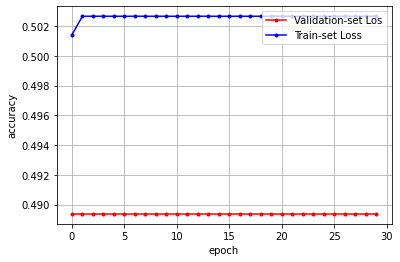

50/50 [==============================] - 1s 9ms/step - loss: 1.3863 - acc: 0.1383
[1.3862948417663574, 0.13625000417232513]


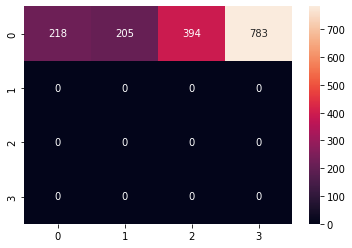

In [50]:
vgg_y_vaccuracy = history_res.history['val_acc'] 
vgg_y_accuracy = history_res.history['acc']

visulization_by_epochs(vgg_y_vaccuracy, vgg_y_accuracy)

result = model_vgg.evaluate(x_val, y_val)
print(result)
#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_vgg.predict(x_val)

draw_confusionmatrix(y_predict, y_val)